In [19]:
import pandas as pd
import numpy as np

from funcs.phaseanalysismulti import OFFSET

import matplotlib.pyplot as plt


In [20]:
def coherence_timescale(period, error):
    """Calculate the coherence timescale from the period and the error on the
    period.

    Parameters
    ----------
    period : float
        The period in days.
    error : float
        The error on the period in days.

    Returns
    -------
    float
        The coherence timescale in days.

    """
    if error == 0:
        return np.inf
    elif ~np.isfinite(error):
        return np.inf

    return period**2 / error




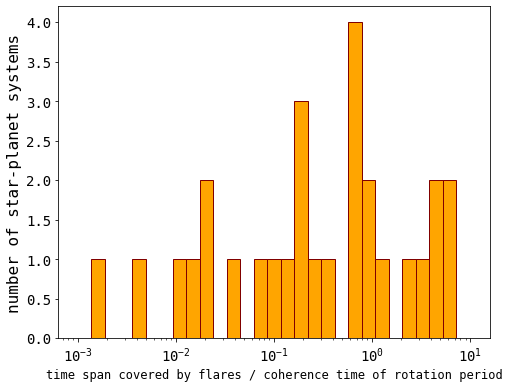

In [33]:
# -
# 1. ROTATION PERIOD COHERENCE

# Read in stellar parameters from the literature
path = "../results/2022_08_stellar_params.csv"
df = pd.read_csv(path)
print(f"Get literature stellar parameters from\n{path}\n")


# Read in flare table
path = "../results/PAPER_flare_table.csv"
flares = pd.read_csv(path)
print(f"Get flare table from\n{path}\n")

# shift each tstart by mission specific offset using mission column and OFFSET
# column
flares["abs_tstart"] = flares.tstart + flares["mission"].apply(lambda x: OFFSET[x])

# Get first and last absolute flare times for each star
tmin = flares.groupby("TIC").abs_tstart.min()
tmax = flares.groupby("TIC").abs_tstart.max()

# merge tmin and tmax into a single DataFrame
tminmax = pd.merge(tmin, tmax, on="TIC", suffixes=("_min", "_max"))

# Calculate the time span between first and last flare
tminmax["time_span_d"] = tminmax["abs_tstart_max"] - tminmax["abs_tstart_min"]

# merge tminmax with the table of stellar parameters
df_timespan = pd.merge(df, tminmax, on="TIC")

g = lambda x: coherence_timescale(x.st_rotp, x.st_rotp_err)
df_timespan["coherence_timescale_rotation_d"] = df_timespan.apply(g, axis=1)

# Calculate the coherence ratio 
# as the ratio between the total time between first and last flare
# and the time it takes to lose the information on rotational phase
# Ideally, the number is << 1
df_timespan["coherence_ratio_rotation"] = (df_timespan["time_span_d"] / 
                                  df_timespan["coherence_timescale_rotation_d"])

# ------------------------------------------------------------------------------
# plot the result and save the file
plt.figure(figsize=(7,5.5))
plt.hist(df_timespan["coherence_ratio_rotation"], bins=np.logspace(-3,1.,30),
         facecolor="orange", edgecolor="maroon")
plt.xscale("log")

plt.xlabel("time span covered by flares / coherence time of rotation period",
            size=12)
plt.ylabel("number of star-planet systems")
plt.tight_layout()
plt.savefig("../results/plots/coherence_time_of_rotation_period.png", dpi=300)
# ------------------------------------------------------------------------------

# write to file
df_timespan.to_csv("../results/2022_09_stellar_params_with_coherence_times.csv", 
                   index=False)

In [45]:
def check_output(tminmax, TIC, separate, missions, per_and_errs):

    system_string = (f"System {TIC}:\n"
                     f"  tmin = {tminmax.loc[TIC, 'tstart_min']:.2f}\n"
                     f"  tmax = {tminmax.loc[TIC, 'tstart_max']:.2f}\n",
                     f"  missions = {missions}\n",
                     f"  periods = {per_and_errs}\n",)
                    #  f"  time span = {tminmax.loc[TIC, 'time_span_d']:.2f}\n")
                    #  f"  orbital_period = {o["pl_orbper"]:.2f}\n""]}"
                    #  f"  orbital_period_err1 = {o['pl_orbpererr1']:.2f}\n"
                    #  f"  orbital_period_err2 = {o['pl_orbpererr2']:.2f}\n"
                    #  f"  orbital_period_tess = {o['pl_orbper_tes']:.2f}\n"
                    #  f"  orbital_period_err1_tess = {o['pl_orbpererr1_tess']:.2f}\n"
                    #  f"  orbital_period_err2_tess = {o['pl_orbpererr2_tess']:.2f}\n")
    # print a message if the orbital period is not finite
    if ~np.isfinite(tminmax["orbper"].values[0]):
        print(f"Orbital period not finite for TIC {row.TIC}")
        print(system_string)
    # print a message if the orbital period error is not finite
    if ~np.isfinite(tminmax["orbper_err"]).values[0]:
        print(f"Orbital period error not finite for TIC {row.TIC}")
        print(system_string)



# 2. ORBITAL PERIOD COHERENCE TIMES
# This is a little more complicated because we sometimes have Kepler transit
# midtimes only but TESS observations without TESS transit midtimes

# Get orbital period of SPSs
path = "../data/2022_07_27_input_catalog_star_planet_systems.csv"
orbits = pd.read_csv(path)
print(f"Get get orbital periods and uncertainties from\n{path}\n")

# Init a coherence timescales table
coherence_timescales_orbit = pd.DataFrame()

# go through the SPSs table
for i, row in df.iterrows():

    # take the real flares for this TIC
    f = flares[(flares["TIC"]==row.TIC) & (flares["orbital_phase"] != -1)]

    # take the orbit
    o = orbits[(orbits["TIC"]==row.TIC)].iloc[0]

    # If both transit midtimes for Kepler and TESS are present
    if (np.isfinite(o.pl_tranmid)) & (np.isfinite(o.pl_tranmid_tess)):
        separate = True
    # Otherwise use the one available
    else:
        separate = False

    # in which missions were flares observed?
    missions = f.mission.unique()

    # in how many missions were flares observed?
    nmissions = missions.size
 
    # If only one mission, pick the min and max flare times without 
    # grouping by mission
    if nmissions == 1:

        # no need to get absolute flare times, just get min and max
        tmin = f.groupby("TIC").tstart.min()
        tmax = f.groupby("TIC").tstart.max()

        # merge the two values into one Series
        tminmax = pd.merge(tmin, tmax, on="TIC", suffixes=("_min", "_max"))

        # select the mission and get the orbital period and the error on the
        # orbital period

        # define coloumns with the orbital period and uncertainty to use
        cols = ["pl_orbper","pl_orbpererr1", "pl_orbpererr2"]

        # if TESS ...
        if missions[0] == "TESS":

            # and TESS available use tess columns
            available_cols = [x for x in cols if np.isfinite(o[f"{x}_tess"])]
            
            if len(available_cols) == 3:
                cols = [f"{x}_tess" for x in cols]
            # ... else use Kepler, that is, cols as given above    
            

        # add them to the Series
        tminmax["orbper"] = o[cols[0]]
        tminmax["orbper_err"] = (o[cols[1]] - o[cols[2]]) / 2.

        check_output(tminmax, row.TIC, separate, missions, o[cols])

    
    # if there are multiple missions, pick the first and last flare times while
    # grouping by mission if separate is True
    elif nmissions == 2:
        if separate:
            tmin = f.groupby(["mission", "TIC"]).tstart.min()
            tmax = f.groupby(["mission", "TIC"]).tstart.max()
            tminmax = pd.merge(tmin, tmax, on=["mission", "TIC"], suffixes=("_min", "_max"))

            # pick the Kepler orbital period for both missions
            tminmax["orbper"] = o.pl_orbper
            tminmax["orbper_err"] = (o.pl_orbpererr1 - o.pl_orbpererr2) / 2. 
        
        # if separate is False, group by TIC only    
        # because you have both missions present, but only
        else:
            tmin = f.groupby("TIC").abs_tstart.min()
            tmax = f.groupby("TIC").abs_tstart.max()
            tminmax = pd.merge(tmin, tmax, on="TIC", suffixes=("_min", "_max"))
            tminmax = tminmax.rename(index=str, columns={"abs_tstart_min": "tstart_min", 
                                                         "abs_tstart_max": "tstart_max"})

            # select the mission where tranmid time is from and get the orbital 
            # period and the error on the orbital period
            if np.isfinite(o.pl_tranmid):
                tminmax["orbper"] = o.pl_orbper
                tminmax["orbper_err"] = (o.pl_orbpererr1 - o.pl_orbpererr2) / 2. 
            elif np.isfinite(o.pl_tranmid_tess):
                tminmax["orbper"] = o.pl_orbper_tess
                tminmax["orbper_err"] = (o.pl_orbpererr1_tess - o.pl_orbpererr2_tess) / 2.

    # Calculate the time span covered by the flares
    tminmax["timespan_d"] = tminmax["tstart_max"] - tminmax["tstart_min"]

    # Calculate the coherence time of the orbital period
    g = lambda x: coherence_timescale(x.orbper, x.orbper_err)
    tminmax["coherence_timescale_orbit_d"] = tminmax.apply(g, axis=1)

    # append tminmax to coherence_timescales_orbit
    coherence_timescales_orbit = pd.concat([coherence_timescales_orbit, tminmax],
                                            axis=0)



Get get orbital periods and uncertainties from
../data/2022_07_27_input_catalog_star_planet_systems.csv



KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['pl_orbpererr'], dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [16]:
coherence_timescales_orbit["coherence_ratio"] = (coherence_timescales_orbit.timespan_d / 
                                                 coherence_timescales_orbit.coherence_timescale_orbit_d)

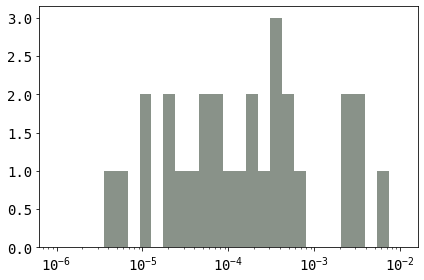

In [17]:
plt.hist(coherence_timescales_orbit["coherence_ratio"], bins=np.logspace(-6,-2,30))
plt.xscale("log")